<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/TensorFlowSteve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta


In [4]:
auth.authenticate_user()

In [5]:
!gcloud config set project {'hackathon-352519'}

Updated property [core/project].


In [6]:
!gsutil cp gs://trains_data/* /tmp/.

Copying gs://trains_data/train-data_all-train-events.zip...
- [1 files][ 57.1 MiB/ 57.1 MiB]                                                
Operation completed over 1 objects/57.1 MiB.                                     


In [7]:
# z = zipfile.ZipFile('train-data_all-train-events.zip', 'r')

x = {}
trains = {}
i = 1
prevLoco = ''
with zipfile.ZipFile("/tmp/train-data_all-train-events.zip", "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                if (prevLoco != currentLoco and "trainActualPositionList" in lastTrainReporting):
                    trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    for position in trainActualPositionList:
                        positions = pd.json_normalize(position)
                        if ("precedingSignalState.milepostLocation.milepostNumber" in positions):
                            trains[i] = pd.json_normalize(lastTrainReporting)
#                             x[i] = pd.concat([train.ptcLeadLocomotiveId,trains[i]["trainId.trainSymbol"], trains[i]["trainId.trainDate"], positions], axis=1)
                            x[i] = positions
#                             trains[i] = train 
                            i = i + 1
                            prevLoco = currentLoco
                            

In [8]:
df = pd.concat(x.values())
dfTrains = pd.concat(trains.values())

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2621 entries, 0 to 0
Data columns (total 13 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   positionTime                                          2621 non-null   object 
 1   speedMPH                                              2621 non-null   int64  
 2   milepostLocation.subdivisionId                        2621 non-null   int64  
 3   milepostLocation.trackName                            2621 non-null   object 
 4   milepostLocation.milepost.milepostNumber              2621 non-null   float64
 5   precedingSignalState.milepostLocation.milepostNumber  2621 non-null   float64
 6   precedingSignalState.previousSignalState              2236 non-null   float64
 7   precedingSignalState.currentStateTime                 2236 non-null   object 
 8   precedingSignalState.signalState                      2621 no

In [10]:
dfTrains.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2621 entries, 0 to 0
Data columns (total 44 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   ptcLeadLocomotiveId                                                        2621 non-null   object 
 1   maximumTrainSpeed                                                          2562 non-null   float64
 2   loadedCarCount                                                             2562 non-null   float64
 3   emptyCarCount                                                              2562 non-null   float64
 4   trainLength                                                                2562 non-null   float64
 5   trailingTonnage                                                            2562 non-null   float64
 6   positionHistoryList                                        

In [74]:
actuals = pd.json_normalize(dfTrains.iloc[100]['trainActualPositionList'])
cols = list(actuals.columns)
dfx = (actuals[cols[0:2] + cols[3:5]])
dfx = dfx.rename(columns={"speedMPH" : "speedMPH", "milepostLocation.trackName":"trackName", "milepostLocation.milepost.milepostNumber": "milepostNumber" })
# dfx = dfx.set_index('positionTime')
dfx.head()

,positionTime,speedMPH,trackName,milepostNumber
0,2022-04-21T21:57:32Z,-35,MT 2,325.00015
1,2022-04-21T21:59:32Z,-35,MT 2,323.82498
2,2022-04-21T22:01:32Z,-33,MT 2,322.71332
3,2022-04-21T22:03:32Z,-32,MT 2,321.60822
4,2022-04-21T22:05:32Z,-32,MT 2,320.53006


In [75]:
est = pd.json_normalize(dfTrains.iloc[100]['trainEstimatedPositionList'])  
beop = est.rename(columns={"speedMPH" : "forecastSpeedMPH", "milepostLocation.trackName":"forecastTrackName", "milepostLocation.milepost.milepostNumber": "forecastMilepostNumber" })
# beop = beop.set_index("positionTime") 
beop = beop.drop(columns=["milepostLocation.subdivisionId"])
beop                                                     

,positionTime,forecastSpeedMPH,forecastTrackName,forecastMilepostNumber
0,2022-04-21T21:55:32Z,-35,MT 2,326.18050
1,2022-04-21T21:57:32Z,-39,MT 2,324.97513
2,2022-04-21T21:59:32Z,-43,MT 2,323.59308
3,2022-04-21T22:01:32Z,-47,MT 2,322.07977
4,2022-04-21T22:03:32Z,-50,MT 2,320.45004
...,...,...,...,...
56,2022-04-21T23:47:32Z,-70,MT 2,198.19019
57,2022-04-21T23:49:32Z,-70,MT 2,195.85689
58,2022-04-21T23:51:32Z,-70,MT 2,193.52359
59,2022-04-21T23:53:32Z,-70,MT 2,191.19029


In [79]:
joined = beop.join(dfx, lsuffix='_beop', rsuffix='_actual')
joined

,positionTime_beop,forecastSpeedMPH,forecastTrackName,forecastMilepostNumber,positionTime_actual,speedMPH,trackName,milepostNumber
0,2022-04-21T21:55:32Z,-35,MT 2,326.18050,2022-04-21T21:57:32Z,-35.0,MT 2,325.00015
1,2022-04-21T21:57:32Z,-39,MT 2,324.97513,2022-04-21T21:59:32Z,-35.0,MT 2,323.82498
2,2022-04-21T21:59:32Z,-43,MT 2,323.59308,2022-04-21T22:01:32Z,-33.0,MT 2,322.71332
3,2022-04-21T22:01:32Z,-47,MT 2,322.07977,2022-04-21T22:03:32Z,-32.0,MT 2,321.60822
4,2022-04-21T22:03:32Z,-50,MT 2,320.45004,2022-04-21T22:05:32Z,-32.0,MT 2,320.53006
...,...,...,...,...,...,...,...,...
56,2022-04-21T23:47:32Z,-70,MT 2,198.19019,2022-04-21T23:51:32Z,-41.0,MT 1,255.05879
57,2022-04-21T23:49:32Z,-70,MT 2,195.85689,2022-04-21T23:53:32Z,-45.0,MT 1,253.58781
58,2022-04-21T23:51:32Z,-70,MT 2,193.52359,NaN,NaN,NaN,NaN
59,2022-04-21T23:53:32Z,-70,MT 2,191.19029,NaN,NaN,NaN,NaN


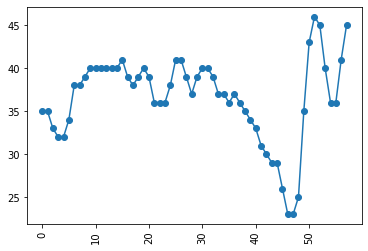

In [96]:
joined.speedMPH.dropna().transform(lambda x: abs(x)).plot(marker='o')
plt.xticks(rotation='vertical')
plt.show()

In [116]:
dn = joined.dropna()
dn = dn.apply(lambda x: abs(x) if x.name=='speedMPH' or  x.name=='forecastSpeedMPH' else x)
dn


,positionTime_beop,forecastSpeedMPH,forecastTrackName,forecastMilepostNumber,positionTime_actual,speedMPH,trackName,milepostNumber
0,2022-04-21T21:55:32Z,35,MT 2,326.18050,2022-04-21T21:57:32Z,35.0,MT 2,325.00015
1,2022-04-21T21:57:32Z,39,MT 2,324.97513,2022-04-21T21:59:32Z,35.0,MT 2,323.82498
2,2022-04-21T21:59:32Z,43,MT 2,323.59308,2022-04-21T22:01:32Z,33.0,MT 2,322.71332
3,2022-04-21T22:01:32Z,47,MT 2,322.07977,2022-04-21T22:03:32Z,32.0,MT 2,321.60822
4,2022-04-21T22:03:32Z,50,MT 2,320.45004,2022-04-21T22:05:32Z,32.0,MT 2,320.53006
5,2022-04-21T22:05:32Z,53,MT 2,318.71580,2022-04-21T22:07:32Z,34.0,MT 2,319.36526
6,2022-04-21T22:07:32Z,56,MT 2,316.88626,2022-04-21T22:09:32Z,38.0,MT 2,318.14896
7,2022-04-21T22:09:32Z,58,MT 2,314.97418,2022-04-21T22:11:32Z,38.0,MT 2,316.86530
8,2022-04-21T22:11:32Z,60,MT 2,312.98100,2022-04-21T22:13:32Z,39.0,MT 2,315.55220
9,2022-04-21T22:13:32Z,63,MT 2,310.91205,2022-04-21T22:15:32Z,40.0,MT 2,314.21460


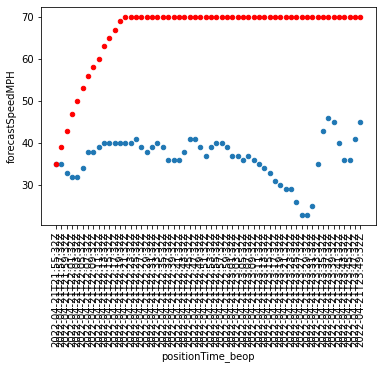

In [117]:
ax = plt.gca()
dn.plot(x="positionTime_beop", y="speedMPH", kind="scatter", ax=ax )
dn.plot(x="positionTime_beop", y="forecastSpeedMPH", kind="scatter", color="red", ax=ax )

plt.xticks(rotation='vertical')
plt.show()

In [ ]:
cols = list(dfTrains.columns)
df3 = dfTrains[[cols[0]] + cols[12:15]+ [cols[21]]]
df3.head()

,ptcLeadLocomotiveId,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,aotuTrainData.categoryCode
0,UP2528,,MGBNP,2022-04-15,12
0,UP2528,,MGBNP,2022-04-15,12
0,UP2528,,MGBNP,2022-04-15,12
0,UP2528,,MGBNP,2022-04-15,12
0,UP2528,,MGBNP,2022-04-15,12


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2621 entries, 0 to 0
Data columns (total 13 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   positionTime                                          2621 non-null   object 
 1   speedMPH                                              2621 non-null   int64  
 2   milepostLocation.subdivisionId                        2621 non-null   int64  
 3   milepostLocation.trackName                            2621 non-null   object 
 4   milepostLocation.milepost.milepostNumber              2621 non-null   float64
 5   precedingSignalState.milepostLocation.milepostNumber  2621 non-null   float64
 6   precedingSignalState.previousSignalState              2236 non-null   float64
 7   precedingSignalState.currentStateTime                 2236 non-null   object 
 8   precedingSignalState.signalState                      2621 no

In [ ]:
# df = df.drop(columns=['milepost'])
df['milepost'] = df.apply(lambda row: math.trunc(row['milepostLocation.milepost.milepostNumber']), axis=1)
df['millis'] = df.apply(lambda row: ((datetime.strptime(row['positionTime'], "%Y-%m-%dT%H:%M:%SZ"))  - datetime(1970, 1, 1)) // timedelta(milliseconds=1), axis=1)
df.head(10)

,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber,precedingSignalState.milepostLocation.milepostNumber,precedingSignalState.previousSignalState,precedingSignalState.currentStateTime,precedingSignalState.signalState,nextSignalState.milepostLocation.milepostNumber,nextSignalState.signalState,nextSignalState.previousSignalState,nextSignalState.currentStateTime,milepost,millis
0,2022-04-17T03:22:02Z,11,106,MT 1,202.74315,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650165722000
0,2022-04-17T03:24:02Z,0,106,MT 1,202.89820,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650165842000
0,2022-04-17T03:26:02Z,0,106,MT 1,202.89820,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650165962000
0,2022-04-17T03:28:02Z,0,106,MT 1,202.89820,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650166082000
0,2022-04-17T03:30:02Z,0,106,MT 1,202.89800,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650166202000
0,2022-04-17T03:32:02Z,0,106,MT 1,202.89800,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650166322000
0,2022-04-17T03:34:02Z,4,106,MT 1,203.04080,202.73,4.0,2022-04-17T03:21:52Z,1,204.19,4.0,NaN,NaN,203,1650166442000
0,2022-04-17T03:36:02Z,11,106,MT 1,203.35143,202.73,4.0,2022-04-17T03:21:52Z,1,204.19,4.0,NaN,NaN,203,1650166562000
0,2022-04-17T03:38:02Z,18,106,MT 1,203.90045,202.73,4.0,2022-04-17T03:21:52Z,1,204.19,4.0,NaN,NaN,203,1650166682000
0,2022-04-17T03:40:02Z,26,106,MT 1,204.44950,204.19,4.0,2022-04-17T03:39:35Z,2,205.94,4.0,NaN,NaN,204,1650166802000


In [ ]:
dfAll = pd.concat([df3, df],axis=1)

In [ ]:
dfAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2621 entries, 0 to 0
Data columns (total 20 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   ptcLeadLocomotiveId                                   2621 non-null   object 
 1   trainId.trainSection                                  2621 non-null   object 
 2   trainId.trainSymbol                                   2621 non-null   object 
 3   trainId.trainDate                                     2621 non-null   object 
 4   aotuTrainData.categoryCode                            2621 non-null   int64  
 5   positionTime                                          2621 non-null   object 
 6   speedMPH                                              2621 non-null   int64  
 7   milepostLocation.subdivisionId                        2621 non-null   int64  
 8   milepostLocation.trackName                            2621 no

In [ ]:
dfAll.head()

,ptcLeadLocomotiveId,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,aotuTrainData.categoryCode,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber,precedingSignalState.milepostLocation.milepostNumber,precedingSignalState.previousSignalState,precedingSignalState.currentStateTime,precedingSignalState.signalState,nextSignalState.milepostLocation.milepostNumber,nextSignalState.signalState,nextSignalState.previousSignalState,nextSignalState.currentStateTime,milepost,millis
0,UP2528,,MGBNP,2022-04-15,12,2022-04-17T03:22:02Z,11,106,MT 1,202.74315,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650165722000
0,UP2528,,MGBNP,2022-04-15,12,2022-04-17T03:24:02Z,0,106,MT 1,202.89820,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650165842000
0,UP2528,,MGBNP,2022-04-15,12,2022-04-17T03:26:02Z,0,106,MT 1,202.89820,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650165962000
0,UP2528,,MGBNP,2022-04-15,12,2022-04-17T03:28:02Z,0,106,MT 1,202.89820,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650166082000
0,UP2528,,MGBNP,2022-04-15,12,2022-04-17T03:30:02Z,0,106,MT 1,202.89800,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650166202000


In [ ]:
dfAll.tail()

,ptcLeadLocomotiveId,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,aotuTrainData.categoryCode,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber,precedingSignalState.milepostLocation.milepostNumber,precedingSignalState.previousSignalState,precedingSignalState.currentStateTime,precedingSignalState.signalState,nextSignalState.milepostLocation.milepostNumber,nextSignalState.signalState,nextSignalState.previousSignalState,nextSignalState.currentStateTime,milepost,millis
0,UP6459,,MPRNP,2022-04-09,12,2022-04-11T00:36:34Z,34,106,MT 1,247.75676,245.93,4.0,2022-04-11T00:33:47Z,2,247.98,4.0,9.0,2022-04-11T00:24:15Z,247,1649637394000
0,UP6459,,MPRNP,2022-04-09,12,2022-04-11T00:38:34Z,29,106,MT 1,248.75430,247.98,4.0,2022-04-11T00:36:59Z,1,249.62,4.0,NaN,NaN,248,1649637514000
0,UP6459,,MPRNP,2022-04-09,12,2022-04-11T00:40:34Z,27,106,MT 1,249.62857,249.62,4.0,2022-04-11T00:40:43Z,2,251.06,4.0,NaN,NaN,249,1649637634000
0,UP6459,,MPRNP,2022-04-09,12,2022-04-11T00:42:34Z,26,106,MT 1,250.50282,249.62,4.0,2022-04-11T00:40:43Z,2,251.06,4.0,NaN,NaN,250,1649637754000
0,UP6459,,MPRNP,2022-04-09,12,2022-04-11T00:44:34Z,25,106,MT 1,251.32497,251.06,4.0,2022-04-11T00:44:07Z,2,252.46,4.0,4.0,2022-04-11T00:32:59Z,251,1649637874000


In [ ]:

val = dfAll.iloc[0,5]
millis = ((datetime.strptime(val, "%Y-%m-%dT%H:%M:%SZ"))  - datetime(1970, 1, 1)) // timedelta(milliseconds=1)
millis

1650165722000

# dfAll has actual readings by loco/train, 60 per, on

In [ ]:
# Define Utility Functions to build additional data rows

# Create a dataframe row holding a record of position on the train.
def createPositionHistoryFrame(positionHistory) -> dict:
    # The time that the train was at the specific milepost
    # Record the position time as seconds from epoch to use in regression model
    positionTime = positionHistory.get('positionTime')
    # How fast the train is traveling
    speedMPH = positionHistory.get('speedMPH')
    # Milepost location information
    milepostLocation = positionHistory.get('milepostLocation')
    # The unique identifier of the subdivision
    subdivisionId = milepostLocation.get('subdivisionId')
    # The unique identifier fo the milepost
    milepostNumber = milepostLocation.get('milepost').get('milepostNumber')

    # Construct new dataframe record
    return {'PositionTime': positionTime, 'SpeedMPH': speedMPH, 
    'SubdivisionId': subdivisionId, 'MilepostNumber':milepostNumber}

# Create a dataframe row for the identifier information of the trani
def createTrainIdFrame(trainId) -> dict:
    trainSymbol = trainId.get('trainSymbol')
    return {'TrainSymbol': trainSymbol}

# Create data frame for train detail
def createTrainDetailFrame(trainDetail) -> dict:
    maximumTrainSpeed = trainDetail.get('maximumTrainSpeed')
    loadedCarCount = trainDetail.get('loadedCarCount')
    emptyCarCount = trainDetail.get('emptyCarCount')
    trainLength = trainDetail.get('trainLength')
    trailingTonnage = trainDetail.get('trailingTonnage')

    # Construct new dataframe record
    return {'MaximumTrainSpeed': maximumTrainSpeed, 'LoadedCarCount': loadedCarCount, 
    'EmptyCarCount': emptyCarCount, 'TrainLength':trainLength, 'TrailingTonnage':trailingTonnage}

# Baseline #1 - measure the accuracy of the Physics model

### Part 1: L1 Norm and L2 Norm of Projected Speed versus Actual

In [6]:
time = torch.arange(0,60).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59.])

In [ ]:
actuals = 

In [ ]:
def show_preds(predictionsTensor, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(predictionsTensor), color='red')
    ax.set_ylim(-300,100)